In [1]:
from datetime import datetime, timedelta
from itertools import  combinations
import pandas as pd
import numpy as np
import requests
import pytz

In [2]:
STRATEGIES = ["close", "ao", "vi"]
SYMBOLS = ["HUYA", "AAPL", "BAC", "GOOG", "YETI"]
TRADES_TZ = pytz.timezone('America/New_York')
end = datetime.now(tz=TRADES_TZ)
start = end - timedelta(days=365 + 34) # 34 AO Period

In [3]:
def get_data_yahoo(symbol, start, end, interval="1d"):
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{symbol}?period1={start:.0f}&period2={end:.0f}" \
          "&interval={interval}&indicators=quote&includeTimestamps=true&" \
          "events=div%7Csplit%7Cearn".format(
                symbol=symbol,
                start=start.timestamp(),
                end=end.timestamp(),
                interval=interval
          )
    try:
        page = requests.get(url)
    except Exception as exc:
        print(exc)
    else:
        result = page.json().get("chart", {}).get("result")
        if not result:
            print("No result {}: {}".format(symbol, page.text))
        else:
            data = result[0]
            quote = data['indicators']['quote'][0]
            if 'timestamp' not in data and quote:
                print("Unexpected response for {} {}".format(symbol, data))
            else:
                quotes = []
                start_date, end_date = start.date(), end.date()
                for n, ts in enumerate(data.get("timestamp", [])):
                    dt = datetime.fromtimestamp(ts, tz=TRADES_TZ)
                    if start_date <= dt.date() <= end_date:
                        quotes.append(
                            dict(
                                date=dt,
                                open=quote["open"][n],
                                high=quote["high"][n],
                                low=quote["low"][n],
                                close=quote["close"][n],
                                volume=quote["volume"][n],
                            )
                        )
                return quotes, data

In [4]:
def get_dataframe(symbol):
    items, _ = get_data_yahoo(symbol, start, end)
    df = pd.DataFrame(items)
    df.set_index("date", inplace=True)
    
    # just price
    df['buy_close'] = df.close > df.close.rolling(window=19).max().shift(1)
    df['sell_close'] = df.close < df.close.rolling(window=19).max().shift(1)
    
    # AO = SMA(High+Low)/2, 5 Periods) - SMA(High+Low/2, 34 Periods)
    high_low_mean = (df.high + df.low) / 2
    df['ao'] = high_low_mean.rolling(window=5).mean() - high_low_mean.rolling(window=34).mean()
    df['buy_ao'] = (df.ao > 0) & (df.ao.rolling(window=30).mean() < 0)
    df['sell_ao'] = (df.ao < 0) & (df.ao.rolling(window=30).mean() > 0)
    
    # Vortex Indicator
    ss = df.shift(1)
    period = 14
    tr = df.high.combine(ss.close, max) - df.low.combine(ss.close, min)
    trp = tr.rolling(window=period).sum()
    vmp = np.abs(df.high - ss.low)
    vmm = np.abs(df.low - ss.high)
    vi_plus = vmp.rolling(window=period).sum() / trp
    vi_minus = vmm.rolling(window=period).sum() / trp
    df['vi'] = vi_plus - vi_minus
    df['buy_vi'] = df.vi >= 0
    df['sell_vi'] = df.vi < 0
    
    return df[["close", "buy_close", "sell_close", "ao", "buy_ao", "sell_ao", "vi", "buy_vi", "sell_vi"]]

In [5]:
def get_profit(df, strats):
    df = df.copy()
    
    # prepare signals
    df["buy"] = True
    for s in strats:
        df["buy"] = df.buy & df["buy_" + s]
        
    df["sell"] = True
    for s in strats:
        df["sell"] = df.sell & df["sell_" + s]
    
    bs_df = df[df.buy | df.sell]
    
    # get profit
    
    df["profit"] = 0
    df["sell_sig"] = 0
    df["buy_sig"] = 0
    bought = None
    
    for r in bs_df.itertuples():
        profit = 0
        if r.buy:
            if bought is None:
                bought = r.close
                df.loc[r.Index, ["buy_sig"]] = r.close
                
        elif r.sell:
            if bought is not None:
                profit = r.close - bought
                bought = None
                df.loc[r.Index, ["sell_sig"]] = r.close
                
        if profit:
            df.loc[df.index >= r.Index, ["profit"]] += profit
    
    return df

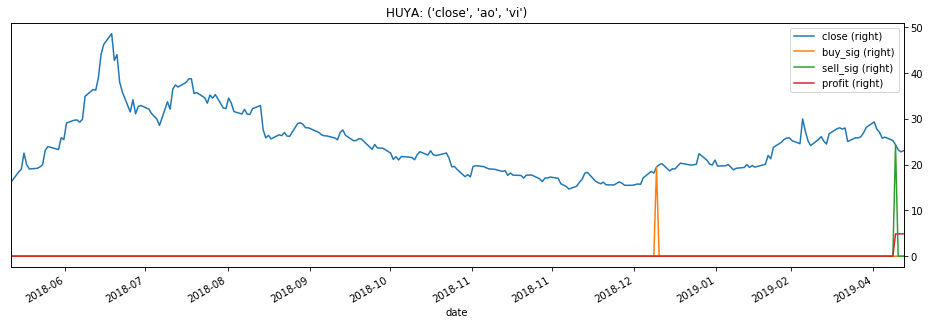

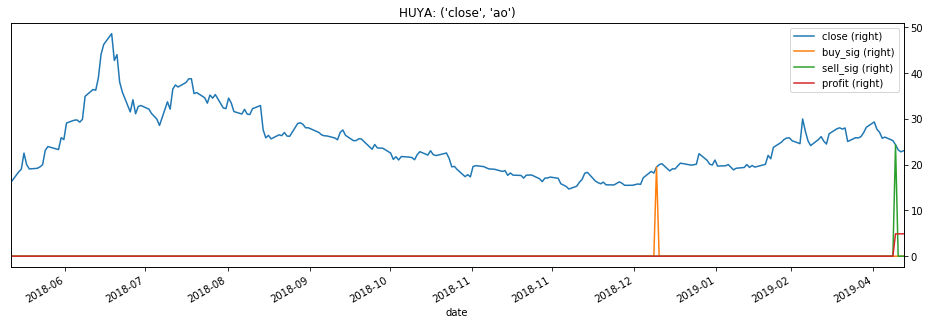

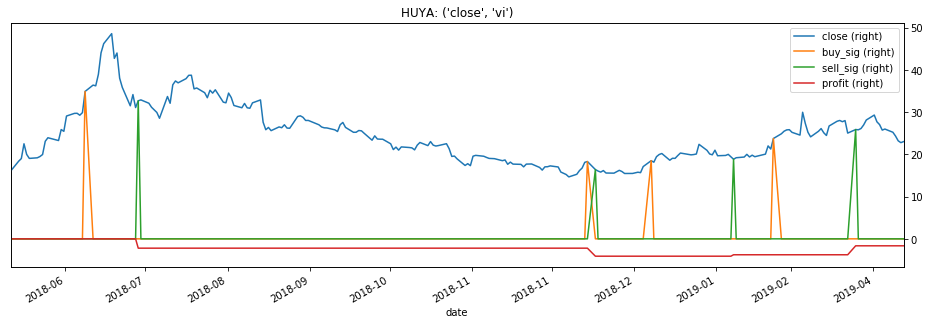

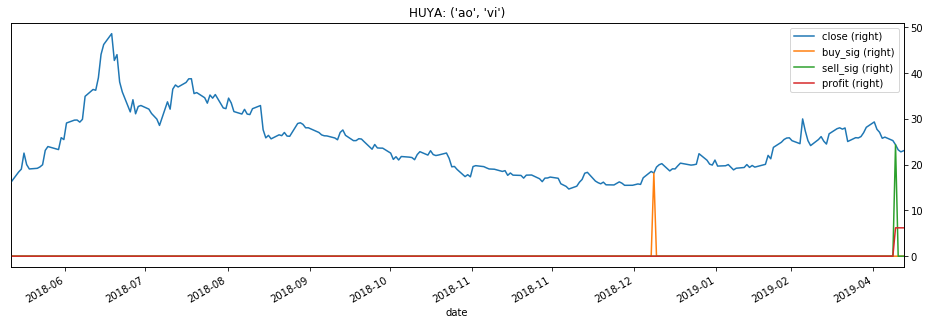

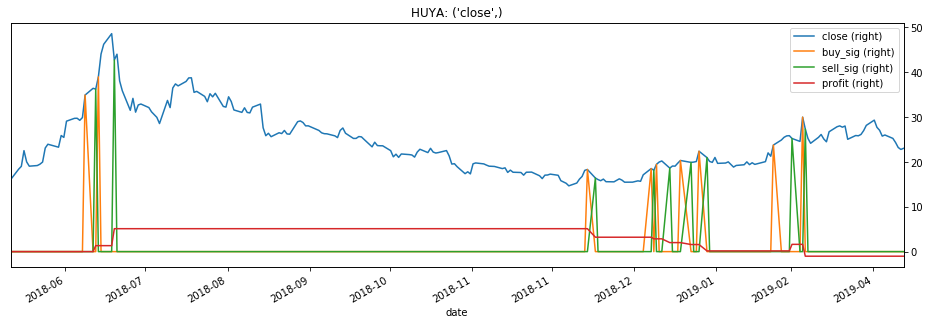

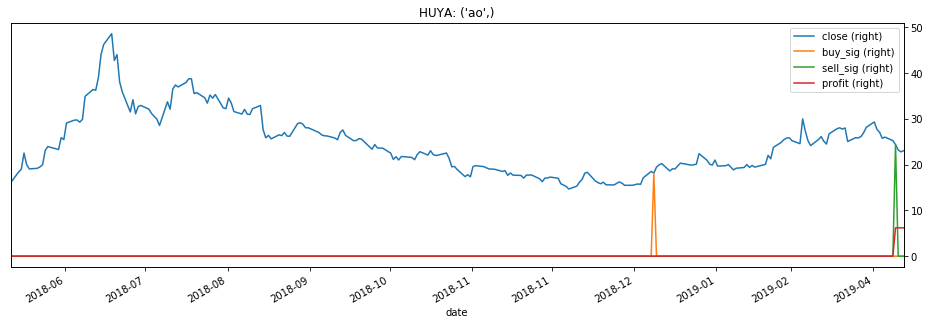

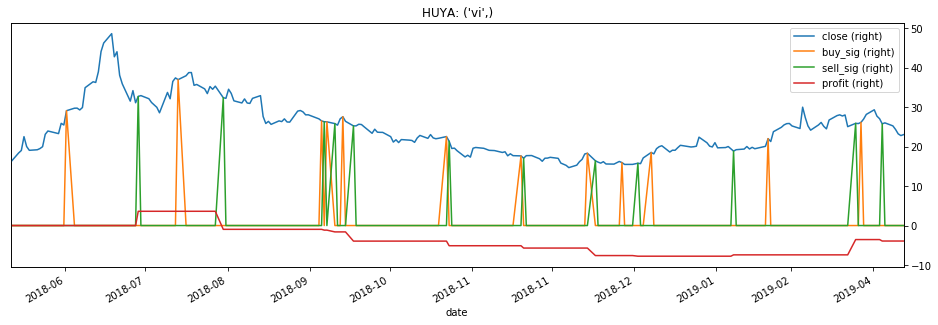

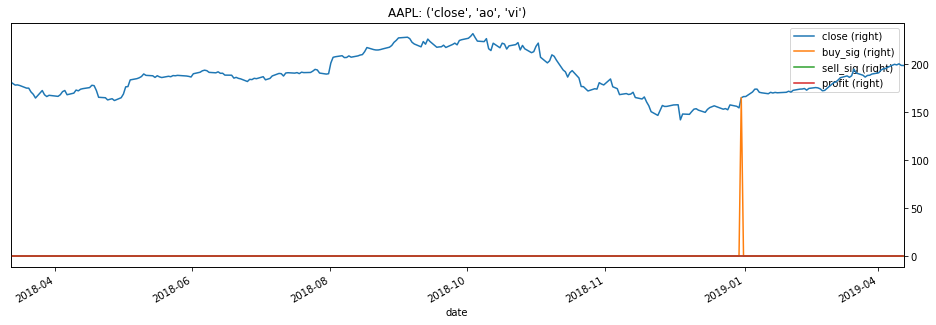

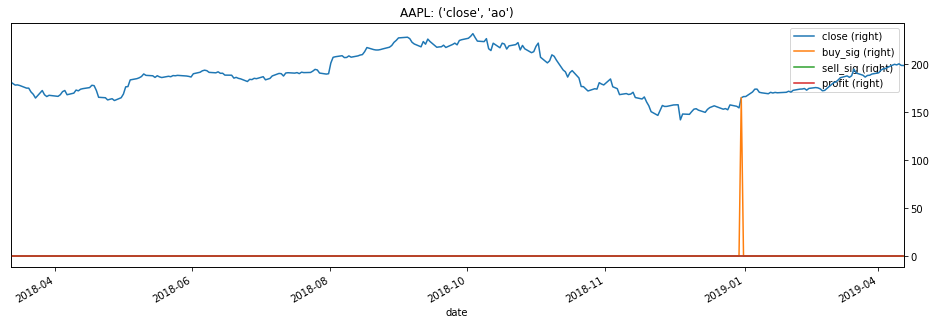

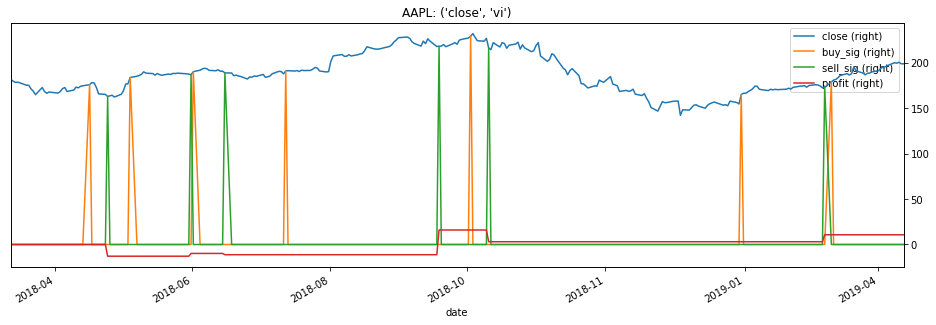

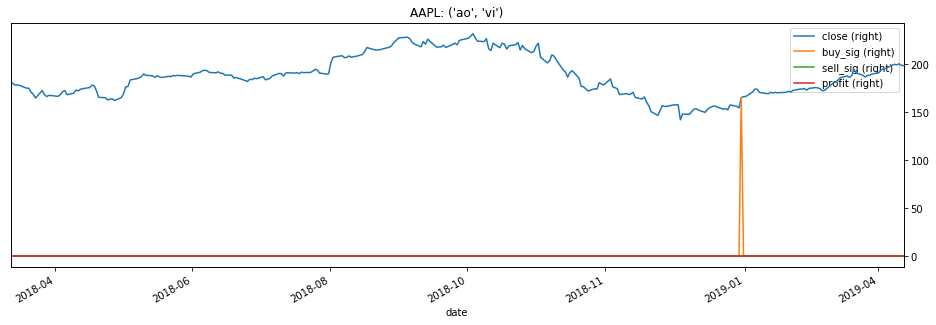

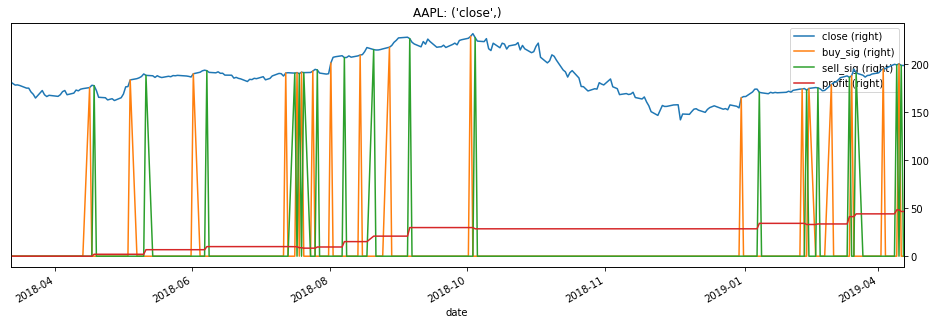

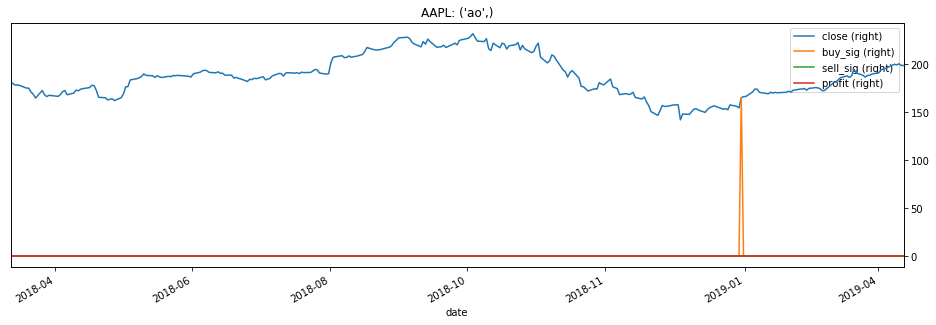

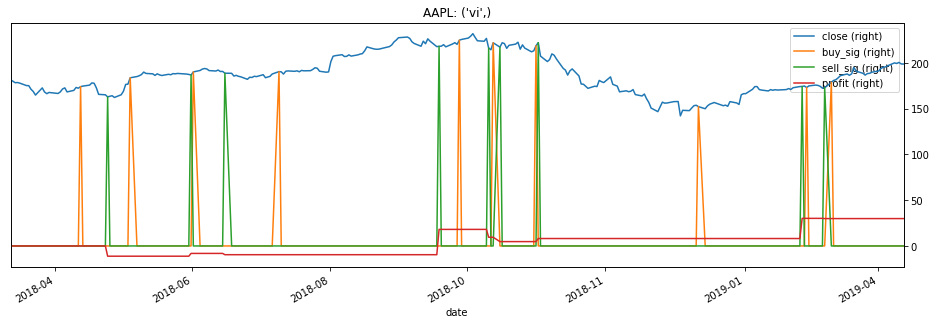

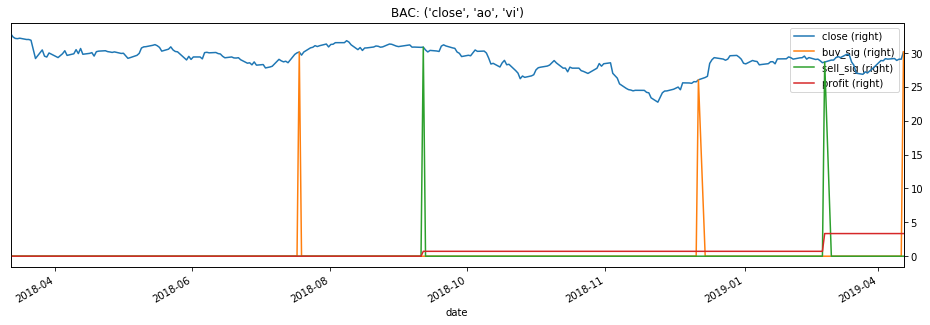

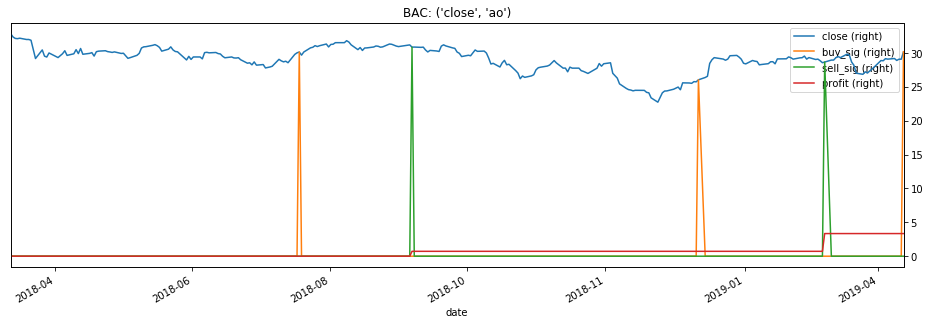

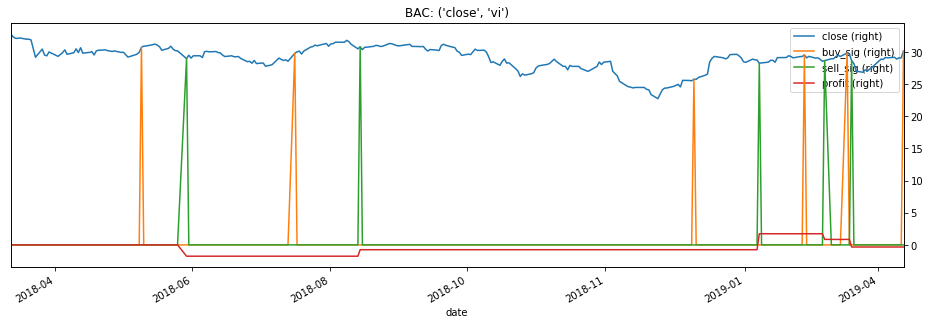

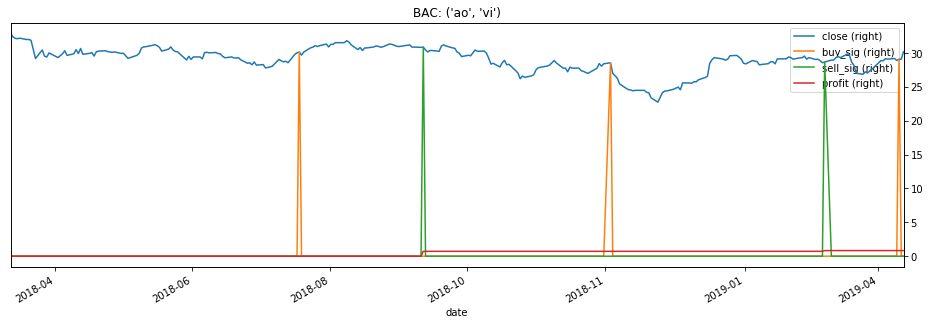

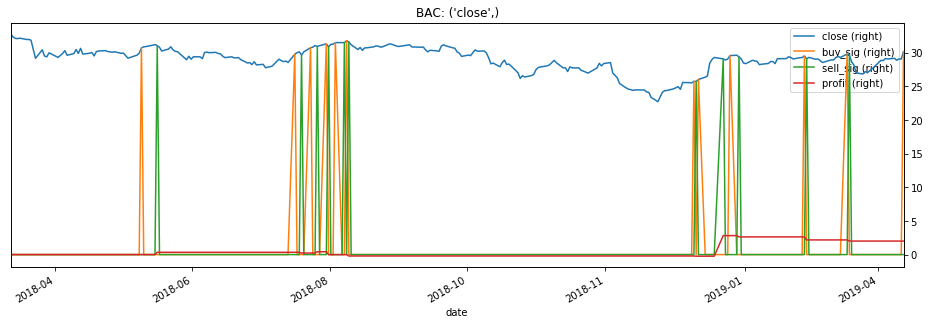

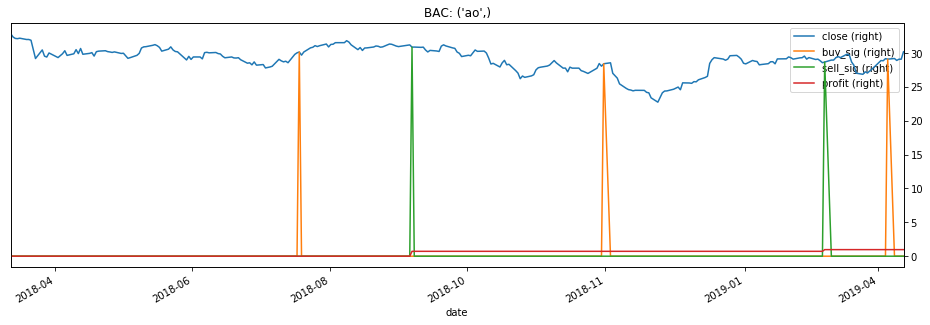

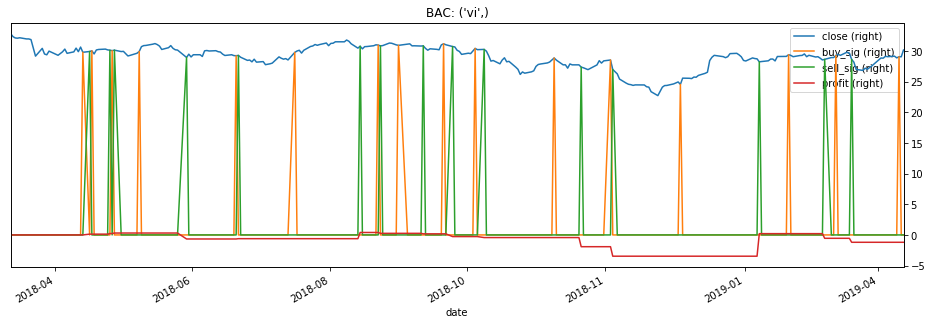

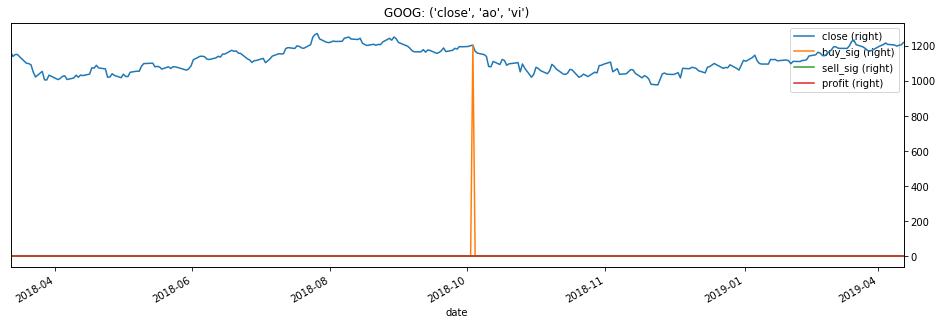

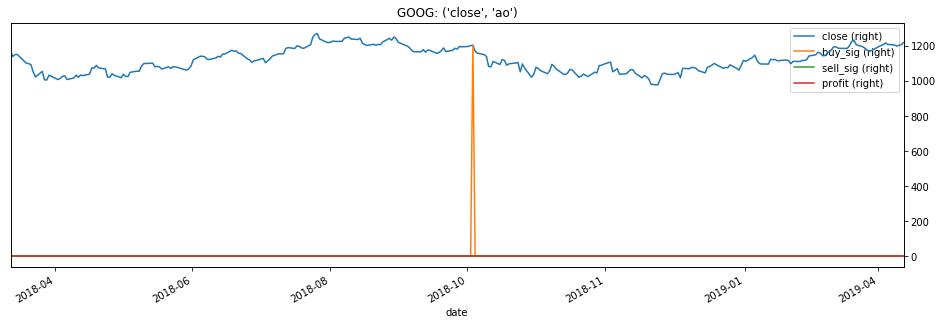

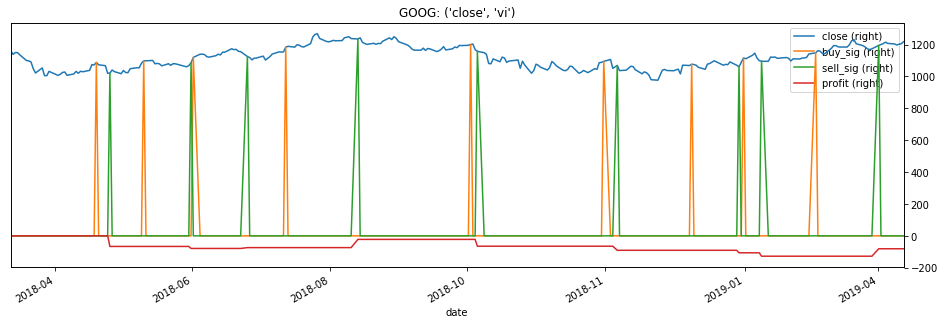

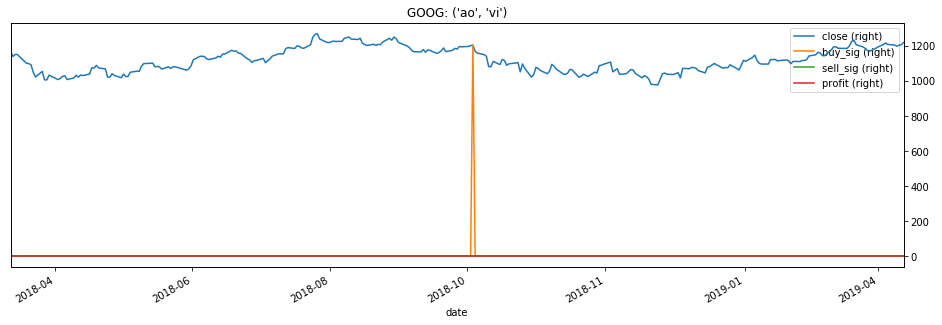

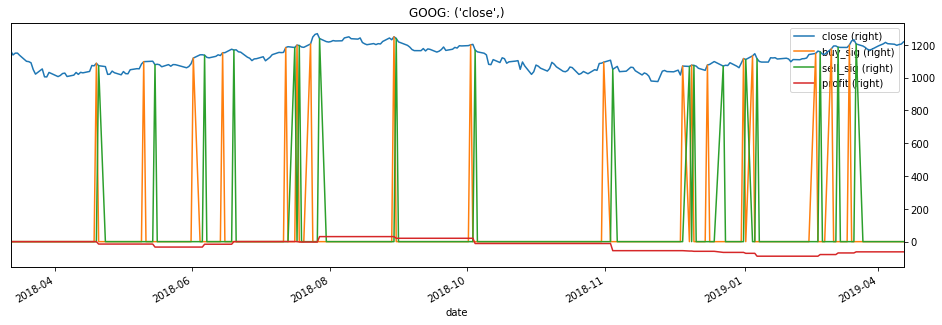

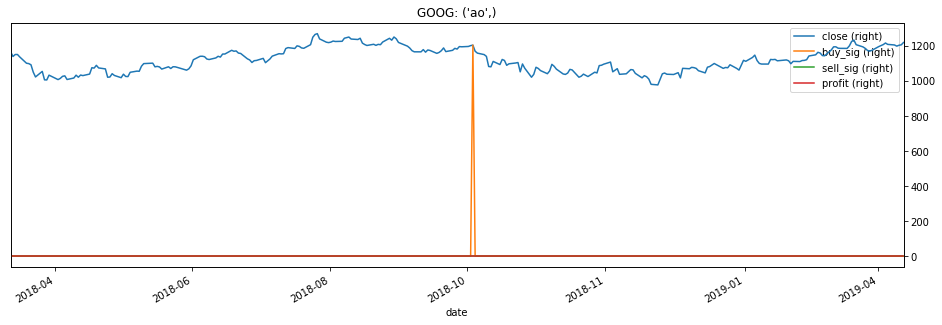

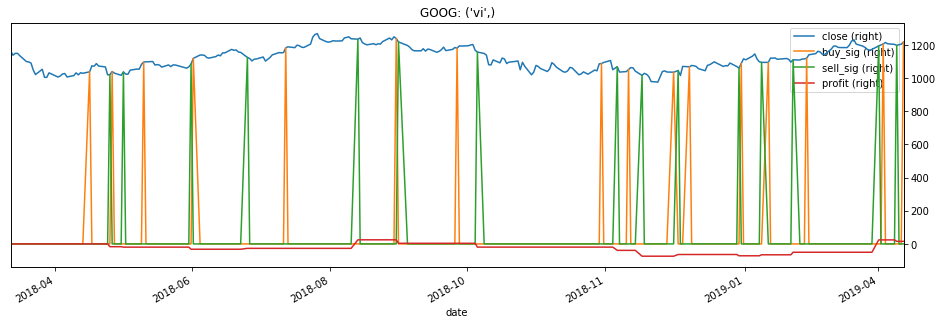

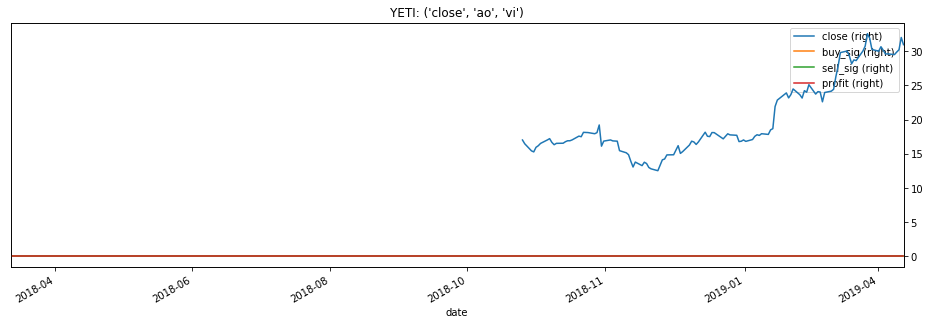

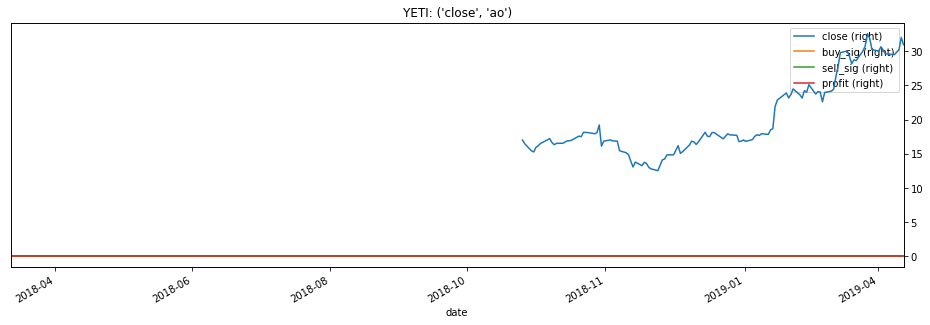

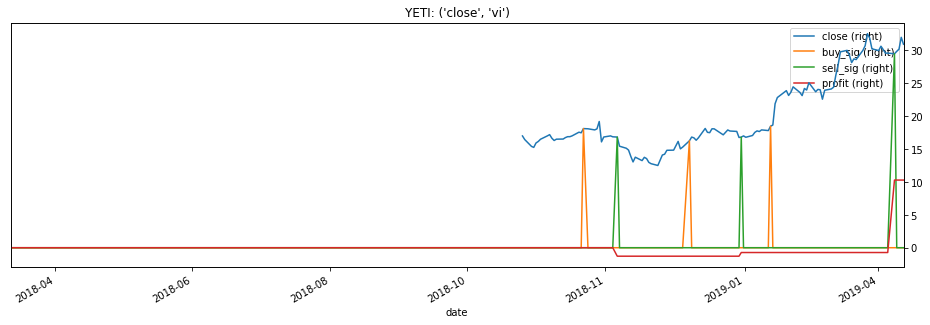

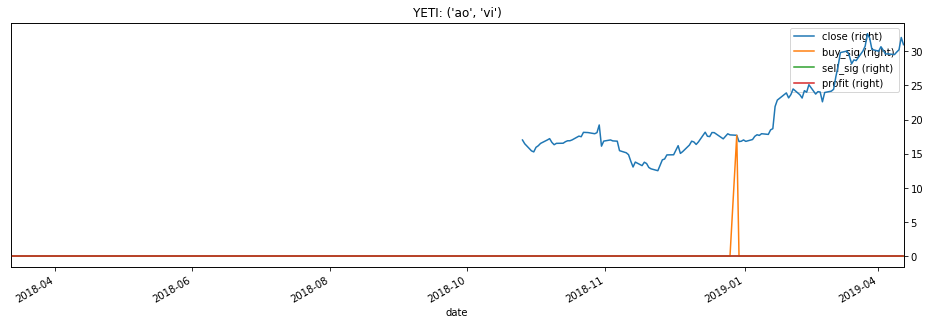

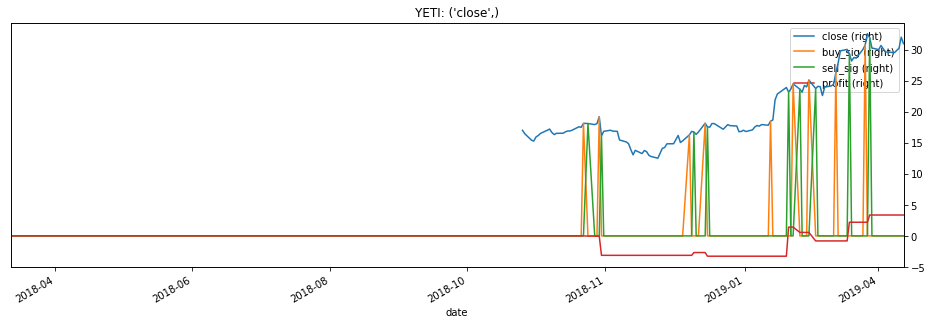

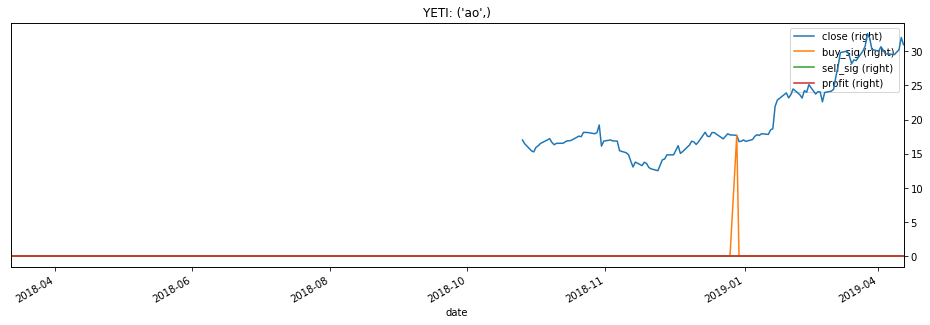

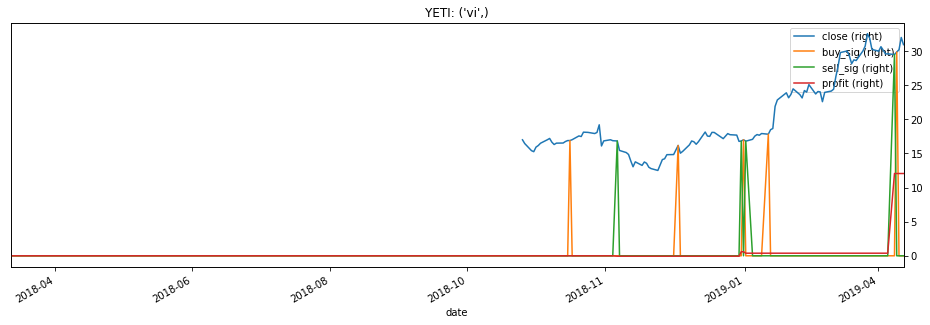

In [8]:
%matplotlib inline

for symbol in SYMBOLS:
    for i in reversed(range(1, len(STRATEGIES) + 1)):
        for strats in combinations(STRATEGIES, i):
            df = get_dataframe(symbol)
            profit_df = get_profit(df, strats)
            profit_df[
                ["close", "buy_sig", "sell_sig", "profit"]
            ].plot(figsize=(16,5), title="{}: {}".format(symbol, strats), secondary_y=True)
            